<a href="https://colab.research.google.com/github/PederRonning/sok-3023/blob/main/sok_3023_utkast_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Starter med å importere to viktig libraries for LSTM

import tensorflow as tf
import pandas as pd

# Leser csv filen
#df = pd.read_csv('NO0010791353_10.02.2025_16.23.44.csv', delimiter=';', names=['date', 'adjusted_price'])
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
#df.head()

In [21]:
# Leser csv filen
#df = pd.read_csv('/content/project/2074251_26.02.2025_08.54.35.csv', delimiter=';', names=['date', 'last'])
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
#df.head()

In [22]:
# Leser csv filen
df = pd.read_csv('/content/project1/OSLO Shipping Historical Data.csv')
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/26/2025,755.22,758.26,763.59,755.09,NaN,-0.39%
1,02/25/2025,758.20,770.23,776.15,758.18,NaN,-1.58%
2,02/24/2025,770.34,788.43,789.70,769.45,NaN,-1.83%
3,02/21/2025,784.68,785.68,798.64,783.19,NaN,-0.11%
4,02/20/2025,785.54,807.68,807.68,783.41,NaN,-2.64%


In [23]:
df.shape

(1298, 7)

In [24]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1293,01/08/2020,223.10,222.60,224.40,222.03,NaN,0.24%
1294,01/07/2020,222.57,221.13,223.48,221.04,NaN,0.65%
1295,01/06/2020,221.13,225.41,226.37,219.40,NaN,-1.89%
1296,01/03/2020,225.39,220.70,225.99,220.70,NaN,2.13%
1297,01/02/2020,220.70,213.92,221.90,213.92,NaN,3.22%


In [25]:
import matplotlib.pyplot as plt
import datetime
# endre format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # dataen er i amerikansk datoformat
df['Price'] = df['Price'].str.replace(',', '').astype(float)

In [26]:
df = df.sort_values(by='Date') # sorter etter dato
# fjern alle kolonner utenom pris og dato
df = df[['Date', 'Price']]

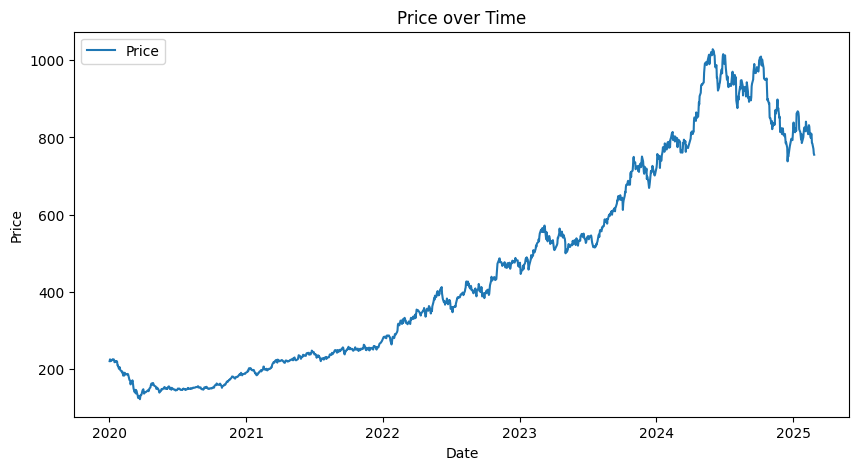

In [27]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'], label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price over Time')
plt.legend()
plt.show()

Prisen på Oslo Børs shipping index over tid, viser en positiv utvikling for de siste 5 årene.

In [28]:
### Funksjon som endrer et 'Object' med splitten '-' til datetime-variabel.
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2]) # Splitter på hver int (heltall)
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2023-02-20')
type(datetime_object)

datetime.datetime

tf_to_windowed_df lages for å transformere data til et format egnet LSTM-modellen. De siste n verdiene brukes for å forutsi neste verdi.

In [29]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Konverter strengdatoer til datetime
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    # Sett 'Date' som indeks og sorter
    dataframe = dataframe.set_index('Date').sort_index()

    target_date = first_date
    dates, X, Y = [], [], []

    last_time = False

    while not last_time:
        # Hent n+1 siste rader opp til target_date
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        # Sjekk om det er nok data
        if len(df_subset) != n + 1:
            print(f"Feil: Vindu av størrelse {n} er for stort for {target_date}")
            return None

        # Hent verdiene (bruk 'Price' istedenfor 'Close')
        values = df_subset['Price'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Finn neste gyldige dato i indeksen
        try:
            current_idx = dataframe.index.get_loc(target_date)
            next_date = dataframe.index[current_idx + 1]
        except IndexError:
            break  # Ingen flere datoer

        target_date = next_date

        # Avslutt hvis vi når siste dato
        if target_date > last_date:
            last_time = True

    # Bygg resultatdataframe
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)

    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Eksempel på bruk
windowed_df = df_to_windowed_df(
    df,
    first_date_str='2020-01-07',
    last_date_str='2025-02-26',
    n=3
)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-01-07,220.70,225.39,221.13,222.57
1,2020-01-08,225.39,221.13,222.57,223.10
2,2020-01-09,221.13,222.57,223.10,224.37
3,2020-01-10,222.57,223.10,224.37,225.60
4,2020-01-13,223.10,224.37,225.60,225.23
...,...,...,...,...,...
1290,2025-02-20,798.75,810.14,806.84,785.54
1291,2025-02-21,810.14,806.84,785.54,784.68
1292,2025-02-24,806.84,785.54,784.68,770.34
1293,2025-02-25,785.54,784.68,770.34,758.20


lager en funksjon: windowed_df_to_date_X_y som brukes for å dele dataen inn i input x og output y for lstm.

In [30]:
# winowed_df

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1295,), (1295, 3, 1), (1295,))

Dataen deles inn i trening (80%), validering (10%) og testsett (10%)


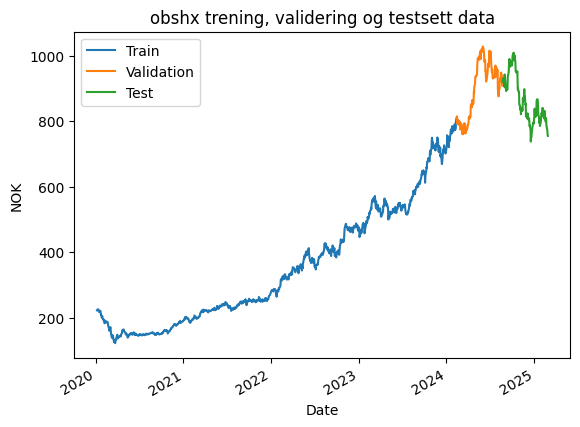

In [31]:
q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

# Formaterer
plt.gcf().autofmt_xdate()

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('obshx trening, validering og testsett data')

plt.legend(['Train', 'Validation', 'Test'])

# Vis plot
plt.show()

Bygge og trene LSTM modellen. Modellen trenes ved treningsdataen og valideres med valideringsdata.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[early_stopping])

#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 153528.5781 - mean_absolute_error: 348.7163 - val_loss: 800368.8125 - val_mean_absolute_error: 890.7526
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 136723.2031 - mean_absolute_error: 323.9652 - val_loss: 694303.8750 - val_mean_absolute_error: 829.0534
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 93088.5469 - mean_absolute_error: 242.4984 - val_loss: 357873.1875 - val_mean_absolute_error: 592.4068
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30109.2285 - mean_absolute_error: 146.9795 - val_loss: 288460.2500 - val_mean_absolute_error: 530.6640
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20160.1465 - mean_absolute_error: 113.0746 - val_loss: 158358.3750 - val_mean_absolute_error: 389.2952
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3673.4551 - mean_absolute_error: 36.6998 - val_loss: 63613.1250 - val_mean_absolute_error: 238.7879
Epoch 7/500
33/33 ━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


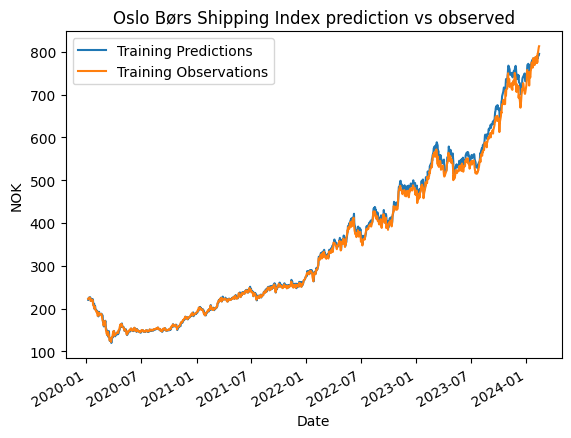

In [33]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

# Formaterer x-aksen
plt.gcf().autofmt_xdate() # auto roter

# labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Oslo Børs Shipping Index prediction vs observed')

plt.show()

Sammenligner modellens prediksjoner med de faktiske observasjonene. Modellen har lært tilpasningen godt

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


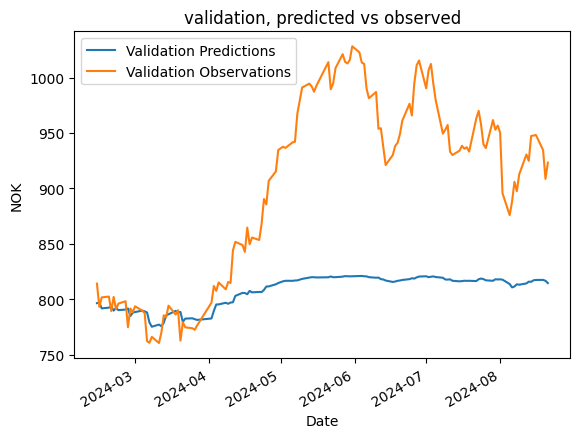

In [34]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

# Formaterer
plt.gcf().autofmt_xdate()


# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('validation, predicted vs observed')

plt.show()

Viser modellens prediksjoner på valideringsdataen.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


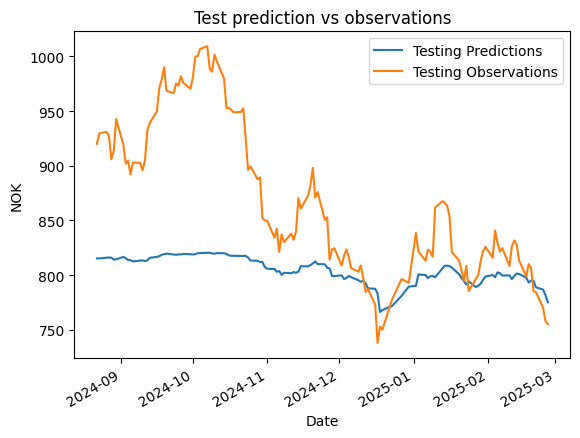

In [35]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Formaterer
plt.gcf().autofmt_xdate()

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Test prediction vs observations')

# Vis plot
plt.show()

Prediksjoner mot dataen modellen ikke har sett under trening eller validering.

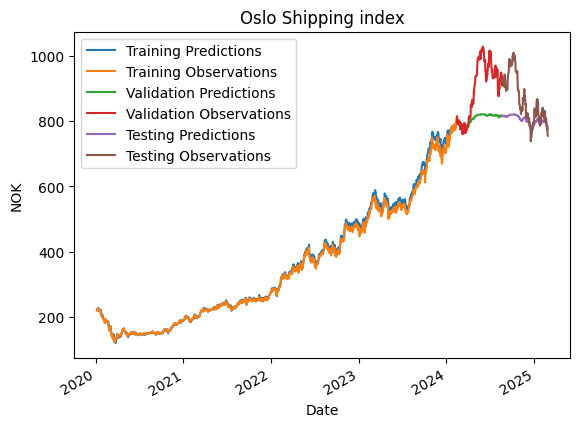

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

# Formaterer
plt.gcf().autofmt_xdate()

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Oslo Shipping index')

plt.show()

Samlett oversikt. Kombinerer alle prediksjonene og observasjonene for treningen, valideringen og testsettet.

Evaluer resultater

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, test_predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, test_predictions)

# Outputs
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 65.7718
Mean Squared Error (MSE): 7523.0337
Root Mean Squared Error (RMSE): 86.7354
R-squared (R²): -0.4994


Modellen fanger ikke opp underliggende mønstre. Det oppstår en brå oppgang i observasjonene som modellen ikke fanger opp.
R-squared er negativ.
